In [31]:
import h5py
import numpy as np
import pandas as pd
import torch
import os
import glob
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#['Large_Nuclear', 'IM_CTC', 'CTCs', 'PC_CTCs', 'CECs', 'Megakaryocytes', 'Large_Vimentin']

classes = {
    0: 'Large Nuclei',
    1: 'imCTCs',
    2: 'CTCs',
    3: 'pcCTCs',
    4: 'CECs',
    5: 'Megakaryocytes',
    6: 'Fibroblasts',
    7: 'Lymph',
    8: 'Gran',
    9: 'Mono'
    
}

colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple',
		  'brown', 'pink', 'olive', 'gray', 'lightgray', 'yellow']

colors_dict = {k: c for k, c in zip(classes.values(), colors)}

In [9]:
# === Scientific Reports figure style ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams.update({
    "font.family":     "Helvetica",   # Sci Rep: single sans-serif family
    "font.size":        8,            # 8 pt everywhere after reduction
    "axes.labelsize":   8,
    "axes.titlesize":   8,
    "xtick.labelsize":  8,
    "ytick.labelsize":  8,
    "legend.fontsize":  8,
    "lines.linewidth":  0.6,          # ≥0.5 pt after final sizing
    "figure.dpi":       300,
})
sns.set_theme(context="paper", style="ticks", rc=mpl.rcParams)


In [10]:
import os
import sys

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../.."))
sys.path.append(project_root)

from src.representation_learning.data_loader import CustomImageDataset
from src.representation_learning.model_cl import CL
from src.utils import utils



np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = 'cuda:0'

#model
#model_path = '/mnt/deepstore/LBxPheno/pipeline/model_weights/representation_model.pth'
model_path = '/mnt/deepstore/Final_DeepPhenotyping/pipeline/model_weights/representation_learning_04_28.pth'
model = CL(in_channels=5, h_dim=128, projection_dim=64)
state_dict = torch.load(model_path)['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
model.to(device)

CL(
  (encoder): Encoder(
    (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (adap_pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=256, out_features=128, bias=True)
  )
  (projector): Sequential(
    (0): Linear(in_features=128, out_features=128, bia

In [11]:
def get_data_loaders(data_path, batch_size=64):
    types = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    images_list = []
    masks_list = []
    labels_list = []
    print(types)
    for label, t in enumerate(types):
        print(t)
        current_type_path = os.path.join(data_path, t)
        current_type_files = glob.glob(os.path.join(current_type_path, "*.hdf5"))
        class_images = []
        class_masks = []


        for file_path in current_type_files:
            with h5py.File(file_path, 'r') as f:
                imgs = np.array(f['images'][:])  # Ensure dtype matches the image data type
                msks = np.array(f['masks'][:])

                class_images.append(imgs)
                class_masks.append(msks)
                
        class_images = np.concatenate(class_images, axis=0)
        class_masks = np.concatenate(class_masks,axis=0)


        # (n, 75, 75, 1) for masks. if (n, 75, 75) then expand dims
        if len(class_masks.shape) == 3:
            class_masks = np.expand_dims(class_masks, axis=-1)
        
        #if mask > 0, then 1
        class_masks[class_masks > 0] = 1

        
        images_list.append(class_images)
        masks_list.append(class_masks)
        labels_list.append(np.full(len(class_images), label, dtype=np.int64))

    # Concatenate lists to form arrays
    
    images = np.concatenate(images_list, axis=0)
    masks = np.concatenate(masks_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    print(images.shape, masks.shape, labels.shape)

    return images, masks, labels

In [12]:
#data_path
dp = '/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/data_dropped_NAN_CECs'
images, masks, labels = get_data_loaders(dp, batch_size=512)

['Large_Nuclear', 'IM_CTC', 'CTCs', 'PC_CTCs', 'CECs', 'Megakaryocytes', 'Large_Vimentin']
Large_Nuclear
IM_CTC
CTCs
PC_CTCs
CECs
Megakaryocytes
Large_Vimentin
(2166, 75, 75, 4) (2166, 75, 75, 1) (2166,)


In [13]:
with h5py.File('/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/0ADD705_gated_full_final.hdf5', 'r') as f:
   wbcimages = f['padded_images'][:]
   wbcmasks = f['masks'][:]
features = pd.read_hdf('/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/0ADD705_gated_full_final.hdf5', 'features')

In [14]:
#if the mask is entirely 0 pixels, then delete the image and mask and the corresponding row in the features

#find the indices of the images that have a mask that is entirely 0 pixels
indices = []
for i in range(len(wbcmasks)):
    if np.sum(wbcmasks[i]) == 0:
        indices.append(i)

#delete the images and masks that have a mask that is entirely 0 pixels
wbcimages = np.delete(wbcimages, indices, axis=0)
wbcmasks = np.delete(wbcmasks, indices, axis=0)

#delete the corresponding rows in the features
features = features.drop(features.index[indices])

In [15]:
#set all non-zero pixels in the mask to 1
wbcmasks[wbcmasks > 0] = 1

In [16]:
wbclabels = features['Multiclass_5'].values

wbclabels[wbclabels == 'Granulocytes'] = 8
wbclabels[wbclabels == 'T-cells'] = 7
wbclabels[wbclabels == 'Monocyte/Macrophages'] = 9
wbclabels[wbclabels == 'B-cells'] = 7
wbclabels[wbclabels == 'NK-cells'] = 7

In [17]:
#set to int
wbclabels = wbclabels.astype(int)

In [18]:
#downsample the wbcimages and masks to 500 for each class (7, 8, 9)
#find the unique labels
unique_labels = np.unique(wbclabels)
#downsample the images and masks to 500 for each class
downsampled_images = []
downsampled_masks = []
downsampled_labels = []

for label in unique_labels:
    #find the indices of the images that have the current label
    indices = np.where(wbclabels == label)[0]
    
    #if there are more than 500 images, then downsample to 500
    if len(indices) > 500:
        indices = np.random.choice(indices, 500, replace=False)
    
    #append the images and masks to the downsampled lists
    downsampled_images.append(wbcimages[indices])
    downsampled_masks.append(wbcmasks[indices])
    downsampled_labels.append(wbclabels[indices])
#concatenate the downsampled lists to form arrays

downsampled_images = np.concatenate(downsampled_images, axis=0)
downsampled_masks = np.concatenate(downsampled_masks, axis=0)
downsampled_labels = np.concatenate(downsampled_labels, axis=0)



In [19]:
#concatenate the images and masks 
images = np.concatenate([images, downsampled_images], axis=0)
masks = np.concatenate([masks, downsampled_masks], axis=0)

#concatenate the labels
labels = np.concatenate([labels, downsampled_labels], axis=0)


In [20]:
dataset = CustomImageDataset(images, masks, labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)


In [21]:
embeddings = utils.get_embeddings(model, dataloader, device)
embeddings = embeddings.numpy()

#scale the embeddings with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

embeddings_df = pd.DataFrame(
    embeddings.astype('float16'),
    columns=[f'z{i}' for i in range(embeddings.shape[1])])

/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [22]:
import umap


reducer = umap.UMAP(n_neighbors=20, min_dist=0.4, metric='cosine', random_state=42)
embedding_umap = reducer.fit_transform(embeddings_df)  
df_data = pd.DataFrame(embedding_umap, columns=['UMAP1', 'UMAP2'])
df_data['label'] = [list(classes.values())[l] for l in labels]

   

/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


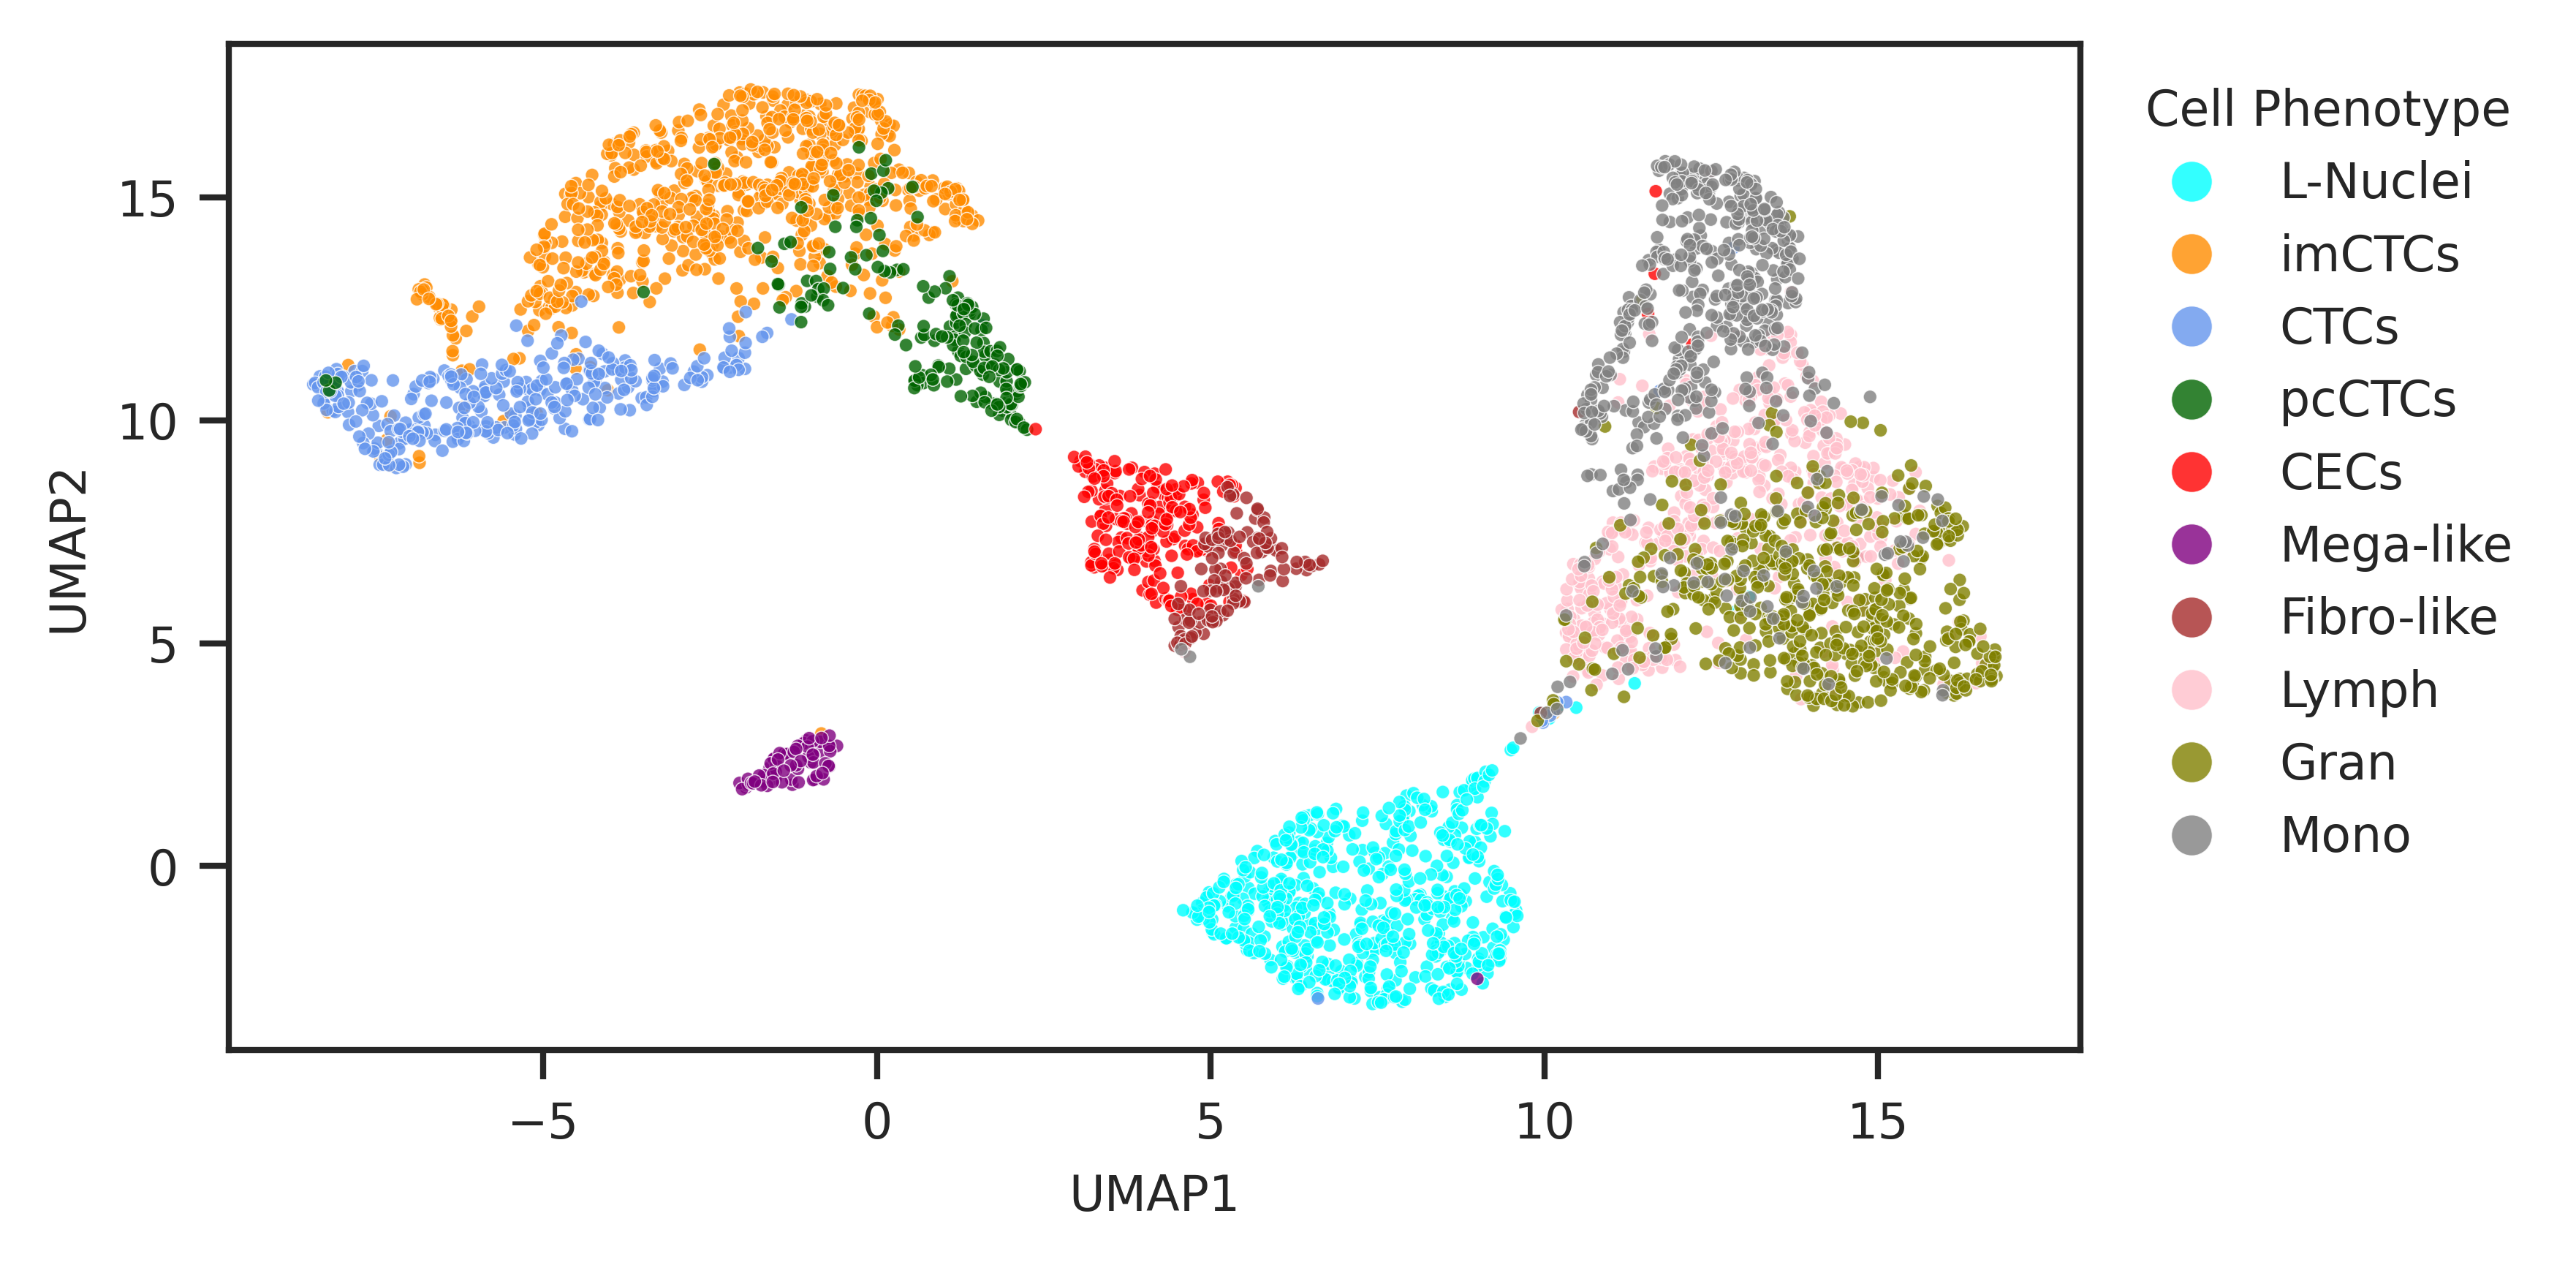

In [23]:

plt.figure(figsize=(6, 3), dpi=600)
sns.scatterplot(data=df_data,
	x='UMAP1', y='UMAP2', hue='label', palette=colors_dict, s=5, alpha=0.8)

# plt.scatter(embedding[:, 0], embedding[:, 1], c=label_colors, s=1)
plt.legend(title='Cell Phenotype', bbox_to_anchor=(1.01, 1), frameon=False, markerscale=3, fontsize=8, title_fontsize=8)
#save figure as 6.5 x 2 inches, 600 dpi
plt.tight_layout()
#set x label size to 8
plt.xlabel('UMAP1', fontsize=8)
#set y label size to 8
plt.ylabel('UMAP2', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
#remove the top and right spines
plt.savefig('/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/umap.pdf',bbox_inches='tight',  dpi=600)
plt.show()

In [24]:
#split data 80/20 for training and testing
np.random.seed(1)  


random_indices = np.random.permutation(len(images))
train_indices = random_indices[:int(0.8*len(images))]
test_indices = random_indices[int(0.8*len(images)):]

train_cl = embeddings[train_indices]
test_cl = embeddings[test_indices]

train_labels = labels[train_indices]
test_labels = labels[test_indices]

print("Train set size: ", len(train_cl), " Test set size: ", len(test_cl))

Train set size:  2932  Test set size:  734


In [25]:
#make sure labels are discrete integers
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

In [26]:
#train a logistic regression model to predict the labels
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

clf = LogisticRegression(max_iter=10000)
clf.fit(train_cl, train_labels)
y_pred = clf.predict(test_cl)

#print accuracy, precision, recall, f1-score
print(f'Accuracy: {accuracy_score(test_labels, y_pred)}')
print(f'Precision: {precision_score(test_labels, y_pred, average="weighted")}')
print(f'Recall: {recall_score(test_labels, y_pred, average="weighted")}')
print(f'F1-score: {f1_score(test_labels, y_pred, average="weighted")}')


Accuracy: 0.9264305177111717
Precision: 0.9291842250625948
Recall: 0.9264305177111717
F1-score: 0.9272360157186254


In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ---------------------------------------------
# Abbreviations (≤ 10 characters each, no legend needed)
abbr = {
    0: "Lrg-Nuclei",
    1: "imCTCs",
    2: "CTCs",
    3: "pcCTCs",
    4: "CECs",
    5: "MegaK-Like",
    6: "Fibro-Like",
    7: "Lymphoid",
    8: "Gran",
    9: "Mono/Mac"
}

cm = confusion_matrix(test_labels, y_pred)

fig, ax = plt.subplots(figsize=(3, 3), dpi=600)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes.values(),
    yticklabels=classes.values(),
    cbar=False,
    annot_kws={"size": 7},
    ax=ax
)

ax.set_xlabel("Predicted", fontsize=8)
ax.set_ylabel("True", fontsize=8)

ax.set_xticklabels(
    ax.get_xticklabels(),
    fontsize=8,
    rotation=45,
    ha="right",
    va="center",
    rotation_mode="anchor"
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

ax.set_aspect("equal")     # keep square cells
plt.tight_layout()

fig.savefig(
    "/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/confusion_matrix.pdf",
    bbox_inches="tight"
)
plt.close(fig)


L-Nuclei 0.9974034067303694
imCTCs 0.9936051448675859
CTCs 0.9950860790030885
pcCTCs 0.9552415918791355
CECs 0.9987652439024391
Mega-like 1.0
Fibro-like 0.9935897435897437
Lymph 0.8438296611174969
Gran 0.8646254735166657
Mono 0.9628765479695623


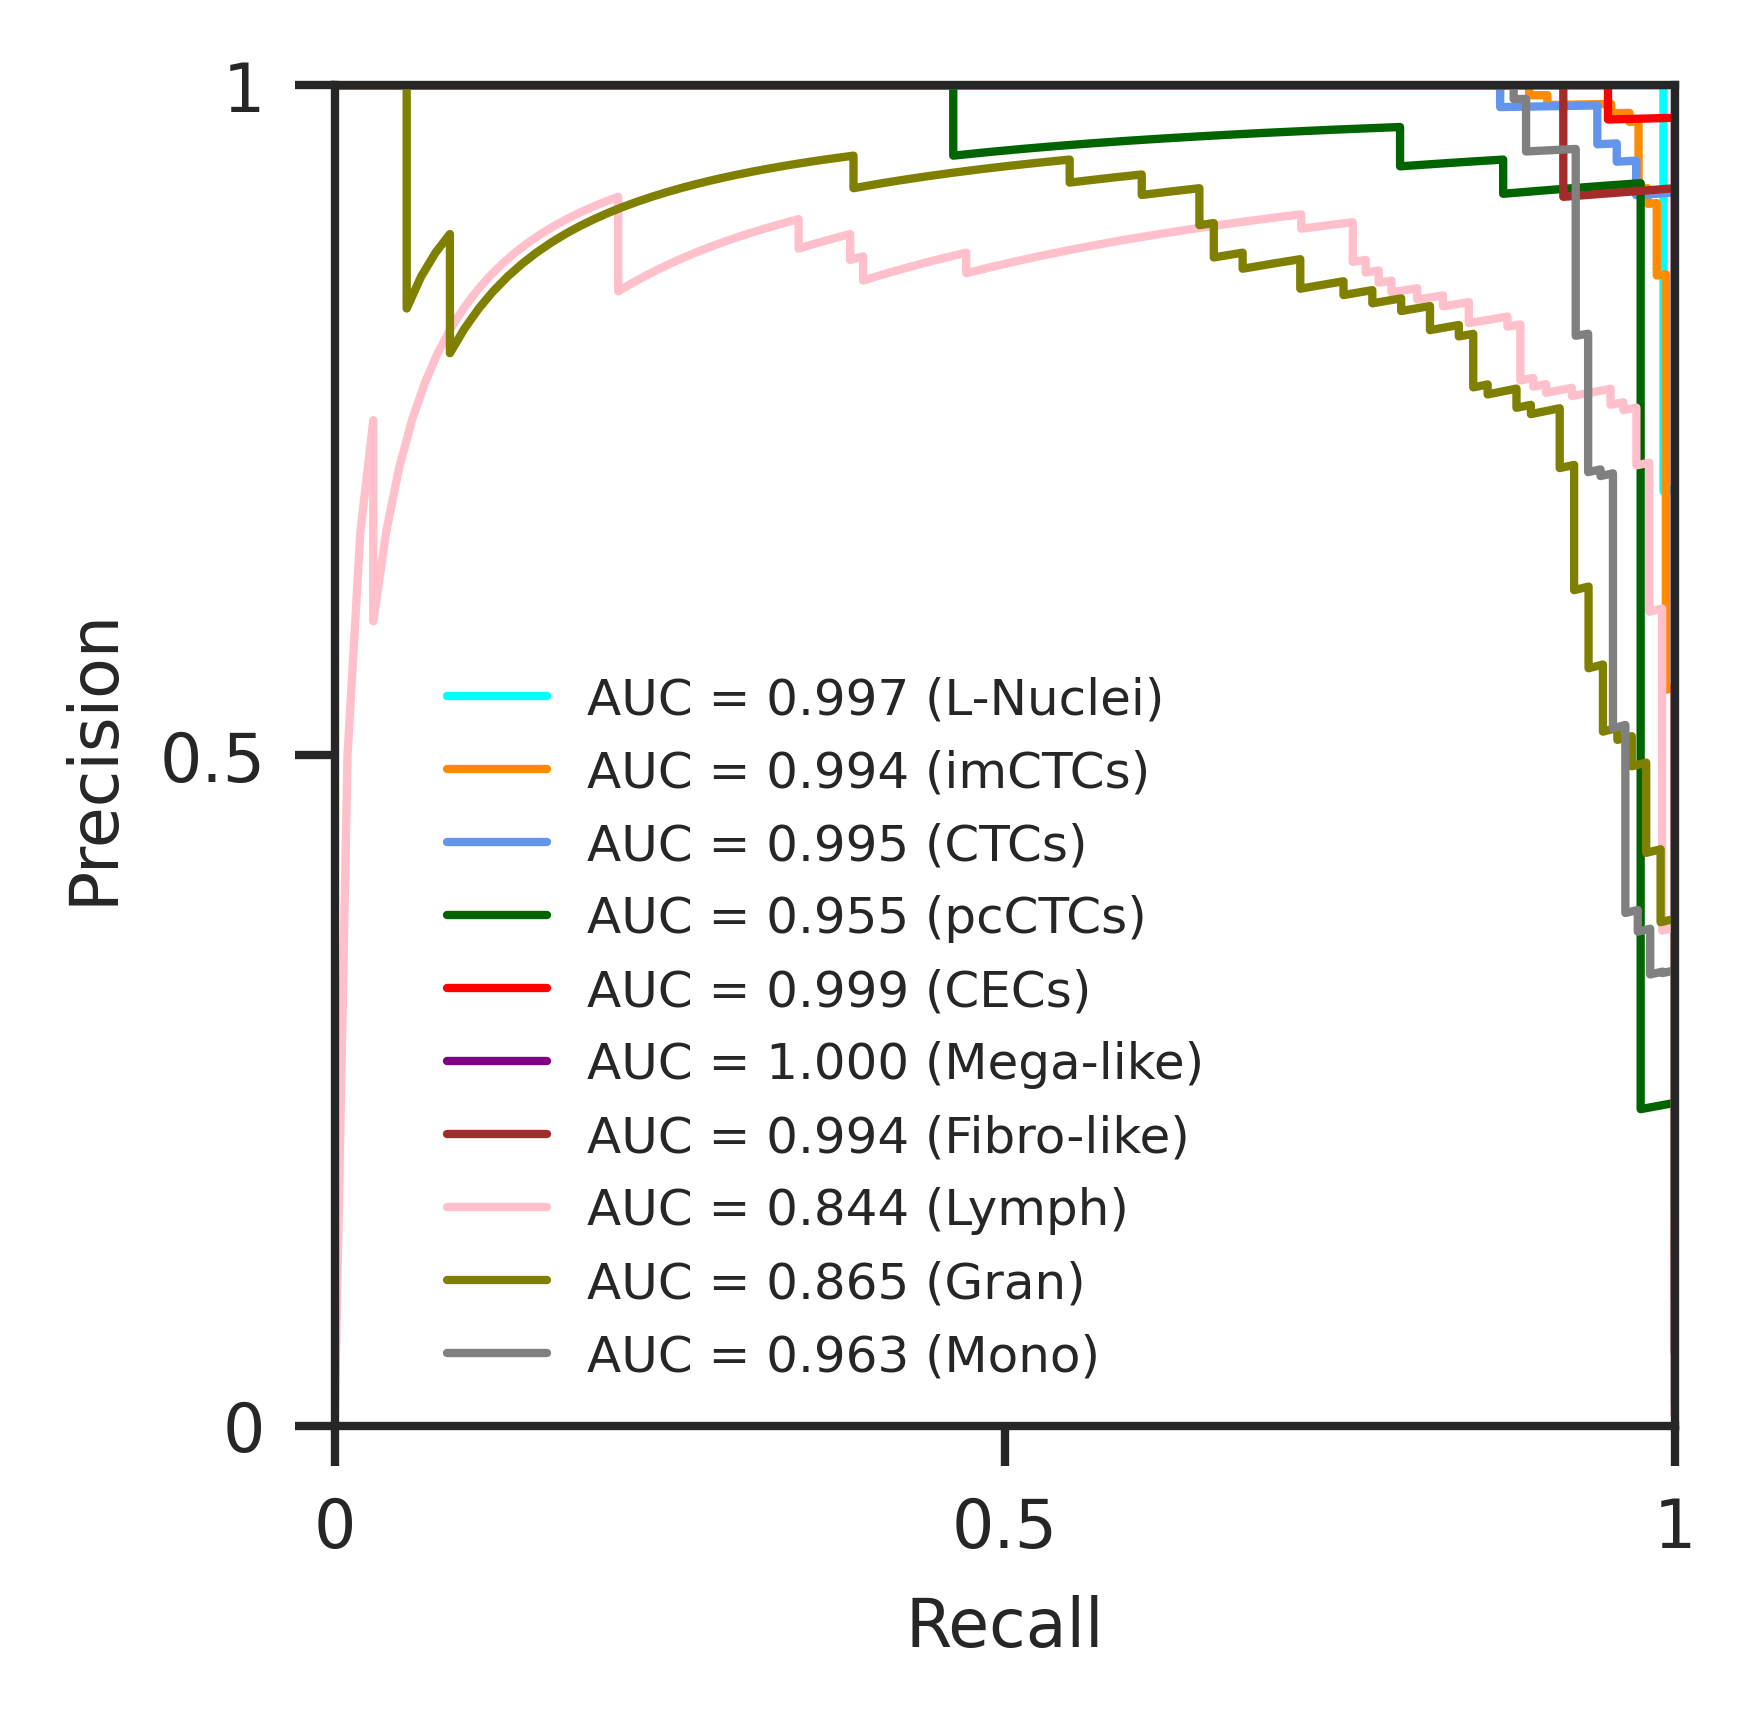

In [28]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming 'test_labels', 'test_cl', and your classifier 'clf' are defined,
# and classes is defined as in your snippet

# Binarize the test labels based on your classes
y_test_binarized = label_binarize(test_labels, classes=list(classes.keys()))
n_classes = len(classes)

# Get the prediction probabilities from your classifier
y_scores = clf.predict_proba(test_cl)

plt.figure(figsize=(3, 3), dpi=600)

for i, class_index in enumerate(classes):
    class_name = classes[class_index]  # Get the class name
    # Calculate precision and recall for the current class
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_scores[:, i])
    # Calculate the average precision score for the current class
    ap = average_precision_score(y_test_binarized[:, i], y_scores[:, i])
    # Use the colors_dict to assign the color based on the class name
    plt.plot(recall, precision, lw=1, label=f'AUC = {ap:.3f} ({class_name})',  # Add AUC to the label
             alpha=1, color=colors_dict[class_name])
    print(class_name, ap)

plt.legend(frameon=False, markerscale=2, loc='lower left', fontsize=6, bbox_to_anchor=(0.05, 0))
plt.xticks([0, 0.5, 1], ['0', '0.5', '1'])
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'])
plt.xlim(0, 1)
plt.ylim(0, 1)
#set font size to 8
plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('/mnt/deepstore/Final_DeepPhenotyping/figures/figure2/precision_recall_curve.pdf', bbox_inches='tight', dpi=600)
plt.show()


In [30]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# one‑vs‑rest binarisation
y_test_bin = label_binarize(test_labels, classes=list(classes.keys()))
n_classes  = y_test_bin.shape[1]

# class‑probability estimates
y_scores = clf.predict_proba(test_cl)

# ── micro averages ─────────────────────────────────────────────
micro_roc_auc = roc_auc_score(y_test_bin, y_scores,
                              average='micro', multi_class='ovr')
micro_pr_auc  = average_precision_score(y_test_bin, y_scores,
                                        average='micro')

print(f"micro ROC‑AUC : {micro_roc_auc:.4f}")
print(f"micro PR‑AUC  : {micro_pr_auc:.4f}")

# ── macro averages (unweighted mean of classwise metrics) ──────
macro_roc_auc = roc_auc_score(y_test_bin, y_scores,
                              average='macro', multi_class='ovr')
macro_pr_auc  = average_precision_score(y_test_bin, y_scores,
                                        average='macro')

print(f"macro ROC‑AUC : {macro_roc_auc:.4f}")
print(f"macro PR‑AUC  : {macro_pr_auc:.4f}")


micro ROC‑AUC : 0.9959
micro PR‑AUC  : 0.9708
macro ROC‑AUC : 0.9938
macro PR‑AUC  : 0.9605
